In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# Regression Network

In [160]:
class LocalizationCNN(nn.Module):
    def __init__(self):
        super(LocalizationCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=3, padding=1), # 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
        )
        
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),  # Adjust the size based on the output of the last convolutional layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)  # Output layer: 4 neurons for x, y coordinates and x, y velocities
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

# Load and prepare the dataset
def load_data(X, Y, training_size=0.8):
    dataset = TensorDataset(X, Y)

    # Splitting dataset into training and validation
    train_size = int(training_size * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    return train_dataset, val_dataset

def train_model(model, device, train_loader, optimizer, loss_function, epochs):
    model.train()
    training_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        training_losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
    return training_losses

def validate_model(model, device, val_loader, loss_function):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, target)
            total_loss += loss.item() * data.size(0)
    avg_loss = total_loss / len(val_loader.dataset)
    print(f'Validation Loss: {avg_loss:.4f}')
    return avg_loss

def plot_learning_curves(training_losses, validation_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses[100:], label='Training Loss')
    plt.plot(validation_losses[100:], label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training

In [153]:
# load training data
X = torch.load('training_images.pt')
Y = torch.load('training_labels.pt')
print(X.shape, Y.shape)

torch.Size([700, 15, 32, 32]) torch.Size([700, 4])


In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Load data
train_dataset, val_dataset = load_data(X, Y[:, :2])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [166]:
# Initialize the model and other components
model = LocalizationCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# Training and Validation
training_losses = train_model(model, device, train_loader, optimizer, loss_function, epochs=500)

Epoch 1, Training Loss: 0.4934
Epoch 2, Training Loss: 0.0929
Epoch 3, Training Loss: 0.1001
Epoch 4, Training Loss: 0.1127
Epoch 5, Training Loss: 0.0937
Epoch 6, Training Loss: 0.0933
Epoch 7, Training Loss: 0.1065
Epoch 8, Training Loss: 0.0922
Epoch 9, Training Loss: 0.0857
Epoch 10, Training Loss: 0.0895
Epoch 11, Training Loss: 0.0842
Epoch 12, Training Loss: 0.0818
Epoch 13, Training Loss: 0.0872
Epoch 14, Training Loss: 0.0918
Epoch 15, Training Loss: 0.0780
Epoch 16, Training Loss: 0.0832
Epoch 17, Training Loss: 0.0824
Epoch 18, Training Loss: 0.0718
Epoch 19, Training Loss: 0.0758
Epoch 20, Training Loss: 0.0740
Epoch 21, Training Loss: 0.0801
Epoch 22, Training Loss: 0.0785
Epoch 23, Training Loss: 0.0662
Epoch 24, Training Loss: 0.0690
Epoch 25, Training Loss: 0.0659
Epoch 26, Training Loss: 0.0759
Epoch 27, Training Loss: 0.0763
Epoch 28, Training Loss: 0.0661
Epoch 29, Training Loss: 0.0617
Epoch 30, Training Loss: 0.0637
Epoch 31, Training Loss: 0.0623
Epoch 32, Trainin

In [119]:
# Save the trained model
torch.save(model.state_dict(), 'localization_cnn.pt')

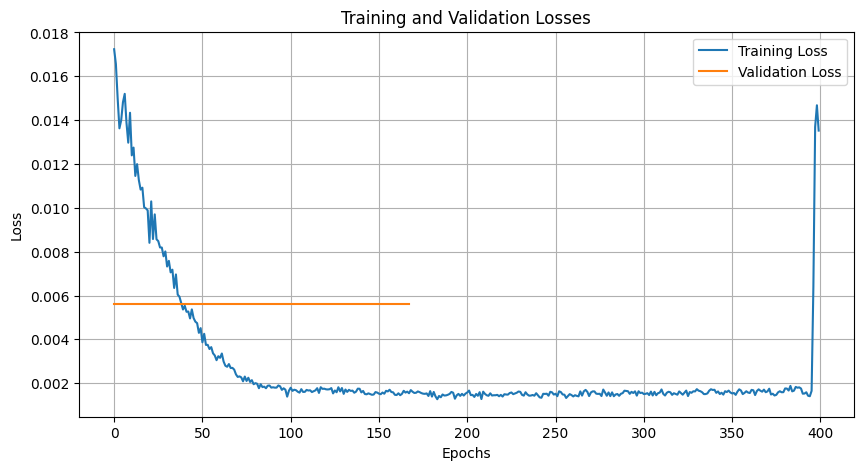

In [168]:
# Plot the learning curves
plot_learning_curves(training_losses, validation_losses)